#### MoBI data access.
Ref here: [link text](https://planetarycomputer.microsoft.com/dataset/mobi#Example-Notebook)

**Environment setup**
This notebook works with or without an API key, but you will be given more permissive access to the data with an API key. The Planetary Computer Hub is pre-configured to use your API key.

In [1]:
# Installs geemap package
import subprocess

!pip install pystac_client 
!pip install planetary_computer     
!pip install rasterio


from pystac_client import Client

import matplotlib.pyplot as plt
import numpy as np
import planetary_computer as pc
import rasterio

     |████████████████████████████████| 132 kB 14.3 MB/s 
     |████████████████████████████████| 63 kB 869 kB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
     |████████████████████████████████| 10.9 MB 13.4 MB/s 
     |████████████████████████████████| 503 kB 63.1 MB/s 
  Attempting uninstall: pytz
    Found existing installation: pytz 2018.9
    Uninstalling pytz-2018.9:
      Successfully uninstalled pytz-2018.9
ERROR: pip's dependency resolver does not currently take into account all the packages that ar

**Querying the dataset**
Let's query the Planetary Computer to get all of the items within the mobi collection.

In [2]:
catalog = Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")
mobi = catalog.search(collections=["mobi"])

items = [item for item in mobi.get_items()]

print(f"Returned {len(items)} Items")

Returned 1 Items


Returned 1 Items

You'll see we only returned a single item for the entire collection. This is a bit different from other types of datasets on the Planetary Computer. In this case, the MoBI rasters are fairly low resolution, so tiling into separate rasters wasn't necessary. They also exist at a single temporal resolution, so each raster in the single item convers the entire CONUS.

Let's see what assets are associated with this item:

In [3]:
item = items[0]
print(*[f"{key}: {asset.description}" for key, asset in item.assets.items()], sep="\n")

RSR_All: Range-size rarity for species
RSR_Plants: Range-size rarity for vascular plants
RSR_Vertebrates: Range-size rarity for vertebrates
RSR_AquaticInverts: Range-size rarity for aquatic invertebrates
PWRSR_GAP12_SUM_All: Protection-weighted range-size rarity for all species
SpeciesRichness_All: Species richness for species
RSR_PollinatorInverts: Range-size rarity for pollinators
PWRSR_GAP12_SUM_Plants: Protection-weighted range-size rarity for vascular plants
SpeciesRichness_Plants: Species richness for vascular plants
PWRSR_GAP12_SUM_Vertebrates: Protection-weighted range-size rarity for vertebrates
SpeciesRichness_Vertebrates: Species richness for vertebrates
PWRSR_GAP12_SUM_AquaticInverts: Protection-weighted range-size rarity for aquatic invertebrates
SpeciesRichness_AquaticInverts: Species richness for aquatic invertebrates
PWRSR_GAP12_SUM_PollinatorInverts: Protection-weighted range-size rarity for pollinators
SpeciesRichness_PollinatorInverts: Species richness for pollinator

**Read and plot a layer**
We've got 15 assets, which each correspond to a different raster. We'll pick the `SpeciesRichness_Vertebrates` asset and plot it by reading the entire file into memory directly from the blob store.

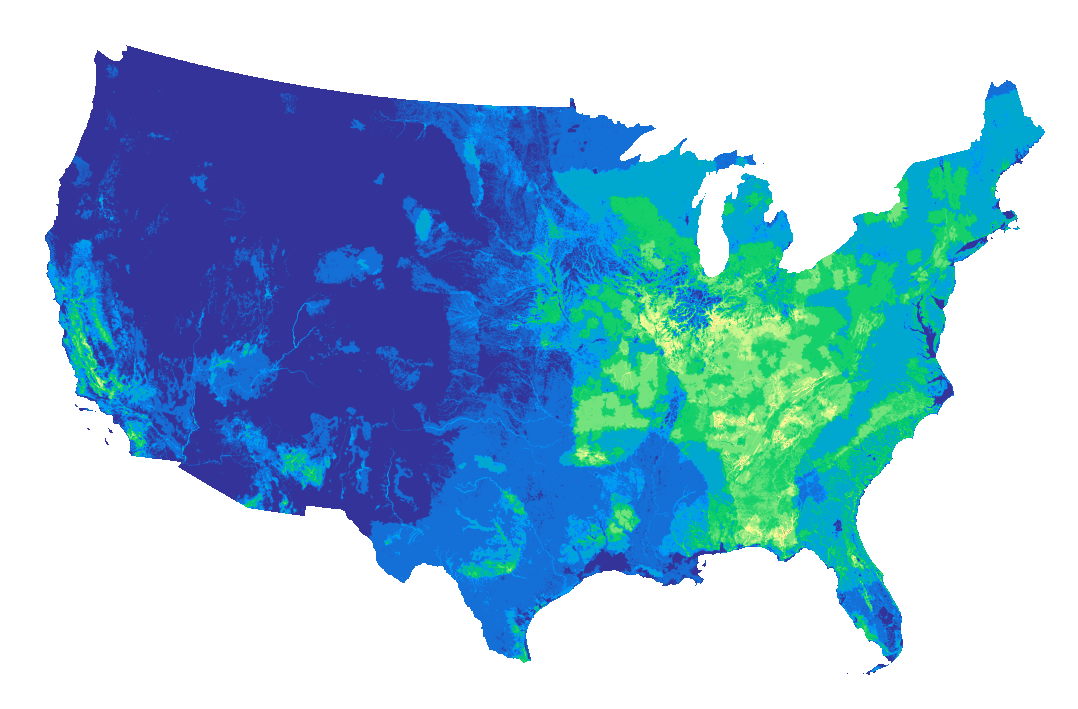

In [4]:
signed_item = pc.sign(item)
vertebrates_richness = signed_item.assets["SpeciesRichness_Vertebrates"]

with rasterio.open(vertebrates_richness.href) as raster:
    data_array = raster.read(1).astype(float)
    raster.close()

# Set nodata values to be transparent
nd_val = raster.nodatavals[0]
data_array[data_array == nd_val] = np.nan

# Plot
fig = plt.figure(figsize=(12, 6), dpi=150, frameon=False)
plt.axis("off")
plt.imshow(data_array, cmap="terrain");